### Imports

In [1]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.visualization.scatter import Scatter

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import Hypervolume

### Definición del problema

In [2]:
class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [3]:
problem = TSPProblem(100)
print(np.shape(problem.distances))
print(np.shape(problem.times))

(100, 100)
(100, 100)


### Funciones auxiliares y cálculo de métricas

#### Punto de referencia calculado: [ 5359.05729263 14825.72799702]

In [4]:
# import numpy as np
# from pymoo.optimize import minimize
# from pymoo.visualization.scatter import Scatter
# from pymoo.indicators.hv import Hypervolume
# from pymoo.termination import get_termination
# from pymoo.algorithms.moo.nsga2 import NSGA2

# def calculate_reference_point(problem, n_gens=1000, num_experiments=10):
#     """
#     Calcula el punto de referencia basado en el peor valor de 10 ejecuciones de NSGA2.

#     @param problem: Problema multiobjetivo.
#     @param n_gens: Número de generaciones por ejecución.
#     @param num_experiments: Número de ejecuciones para calcular el peor valor.

#     @return: Punto de referencia calculado.
#     """
#     worst_values = []

#     # Crear instancia del algoritmo NSGA-II
#     algorithm = NSGA2(pop_size=100)

#     for i in range(num_experiments):
#         # Ejecutar minimización
#         res = minimize(problem, algorithm, ('n_gen', n_gens), verbose=False)
#         front = res.F  # Frente de Pareto
#         # Agregar el peor punto del frente de Pareto actual
#         worst_point = np.max(front, axis=0)
#         worst_values.append(worst_point)

#     # Calcular el peor punto global
#     reference_point = np.max(worst_values, axis=0) * 1.3  # Margen de seguridad
#     print(f"Punto de referencia calculado: {reference_point}")
#     return reference_point

# ref_point = calculate_reference_point(problem, n_gens=1000, num_experiments=10)

#### Métricas utilizadas: Hipervolumen (HV), Dispersión (SPR) y Espaciado (SPA)

In [5]:
def calculate_metrics(front):
    """ Calcula las métricas: hipervolumen, dispersión (SPR) y espaciado (SPA). 
        Se utiliza un punto de referencia fijo para calcular el hipervolumen.
    """
    # Punto de referencia fijo basado en el análisis previo
    ref_point = np.array([5359.05729263, 14825.72799702])

    # Calcular el hipervolumen con respecto al punto de referencia
    metricHV = Hypervolume(ref_point)
    hv = metricHV.do(front)

    # Dispersión: Diagonal de la hipercaja que contiene el frente
    min_values = np.min(front, axis=0)  # Valor mínimo en cada objetivo
    max_values = np.max(front, axis=0)  # Valor máximo en cada objetivo
    spr = np.linalg.norm(max_values - min_values)  # Norma euclidiana de la diferencia entre máximos y mínimos

    # Espaciado: Distancia promedio entre puntos del frente
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)  # Matriz de distancias entre puntos
    spa = np.mean(np.min(d + np.diag(np.inf * np.ones(len(d))), axis=1))  # Promedio de distancias mínimas

    return hv, spr, spa

### NSGA-II

In [74]:
algorithm_nsga2 = NSGA2(pop_size=100)
# Listas para guardar métricas
metrics_summary = []
best_hypervolume = -float('inf')
pareto_nsga2 = None

for i in range(10):
    print(f"\nEjecución {i+1}/{10}:")

    # Ejecutar minimización
    res = minimize(problem, algorithm_nsga2, ('n_gen', 1000), verbose=False)
    front = res.F  # Frente de Pareto (valores de los objetivos)

    # Calcular métricas
    hv, spr, spa = calculate_metrics(front)
    metrics_summary.append((hv, spr, spa))
    print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

    # Guardar el mejor frente según el hipervolumen
    if hv > best_hypervolume:
        best_hypervolume = hv
        pareto_nsga2 = front

# Calcular promedios y desviaciones estándar de las métricas
metrics_summary = np.array(metrics_summary)
mean_metrics = np.mean(metrics_summary, axis=0)
std_metrics = np.std(metrics_summary, axis=0)

print("\n--- Resumen de Métricas ---")
print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")


Ejecución 1/10:
Hipervolumen: 26088202.2124, Dispersión (SPR): 5253.4087, Espaciado (SPA): 11.6183

Ejecución 2/10:
Hipervolumen: 26159170.7704, Dispersión (SPR): 5231.7761, Espaciado (SPA): 24.2600

Ejecución 3/10:
Hipervolumen: 25469141.1802, Dispersión (SPR): 4243.5780, Espaciado (SPA): 13.4451

Ejecución 4/10:
Hipervolumen: 27463609.4227, Dispersión (SPR): 4890.0879, Espaciado (SPA): 20.3759

Ejecución 5/10:
Hipervolumen: 26006431.3226, Dispersión (SPR): 4248.2926, Espaciado (SPA): 21.2121

Ejecución 6/10:
Hipervolumen: 26487056.0394, Dispersión (SPR): 4543.4059, Espaciado (SPA): 20.8300

Ejecución 7/10:
Hipervolumen: 27465963.0274, Dispersión (SPR): 4675.9527, Espaciado (SPA): 13.7261

Ejecución 8/10:
Hipervolumen: 27279547.2343, Dispersión (SPR): 4811.4254, Espaciado (SPA): 8.9373

Ejecución 9/10:
Hipervolumen: 26764742.3580, Dispersión (SPR): 6066.0493, Espaciado (SPA): 26.8194

Ejecución 10/10:
Hipervolumen: 26959754.1174, Dispersión (SPR): 5193.9633, Espaciado (SPA): 15.4318


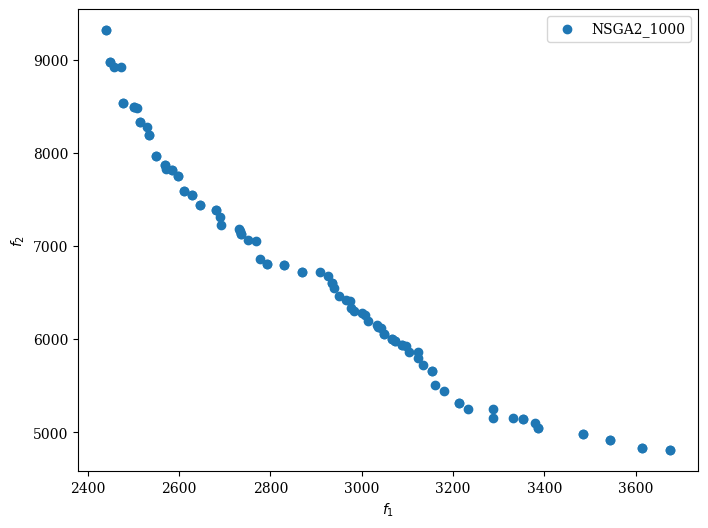

In [75]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.legend=True
scatter.show()

In [13]:
from pymoo.algorithms.moo.spea2 import SPEA2
algorithm_spea2 = SPEA2(pop_size=100)
# Listas para guardar métricas
metrics_summary = []
best_hypervolume = -float('inf')
pareto_spea2 = None

for i in range(10):
    print(f"\nEjecución {i+1}/{10}:")

    # Ejecutar minimización
    res = minimize(problem, algorithm_spea2, ('n_gen', 1000), verbose=False)
    front = res.F  # Frente de Pareto (valores de los objetivos)

    # Calcular métricas
    hv, spr, spa = calculate_metrics(front)
    metrics_summary.append((hv, spr, spa))
    print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

    # Guardar el mejor frente según el hipervolumen
    if hv > best_hypervolume:
        best_hypervolume = hv
        pareto_spea2 = front

# Calcular promedios y desviaciones estándar de las métricas
metrics_summary = np.array(metrics_summary)
mean_metrics = np.mean(metrics_summary, axis=0)
std_metrics = np.std(metrics_summary, axis=0)

print("\n--- Resumen de Métricas ---")
print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")


Ejecución 1/10:
Hipervolumen: 26516290.2051, Dispersión (SPR): 4934.2992, Espaciado (SPA): 32.5794

Ejecución 2/10:
Hipervolumen: 25665655.7847, Dispersión (SPR): 5225.4899, Espaciado (SPA): 40.9445

Ejecución 3/10:
Hipervolumen: 26992052.3644, Dispersión (SPR): 5448.0786, Espaciado (SPA): 21.8838

Ejecución 4/10:
Hipervolumen: 26025434.8551, Dispersión (SPR): 3658.2070, Espaciado (SPA): 18.1917

Ejecución 5/10:
Hipervolumen: 27301209.0803, Dispersión (SPR): 5695.7280, Espaciado (SPA): 43.7280

Ejecución 6/10:
Hipervolumen: 27382793.0251, Dispersión (SPR): 6229.7366, Espaciado (SPA): 46.0236

Ejecución 7/10:
Hipervolumen: 26068587.7942, Dispersión (SPR): 5348.6609, Espaciado (SPA): 30.7175

Ejecución 8/10:
Hipervolumen: 24041749.1970, Dispersión (SPR): 5698.9217, Espaciado (SPA): 41.6717

Ejecución 9/10:
Hipervolumen: 27154107.5656, Dispersión (SPR): 6035.6038, Espaciado (SPA): 32.1231

Ejecución 10/10:
Hipervolumen: 24953305.3529, Dispersión (SPR): 4901.7191, Espaciado (SPA): 35.3506

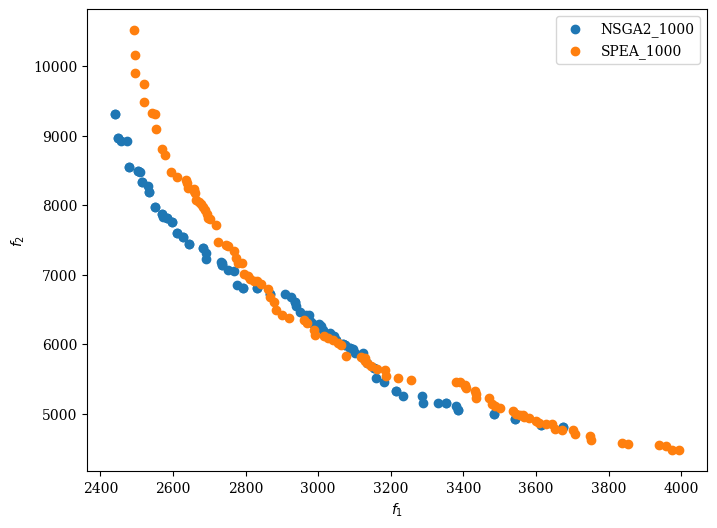

In [76]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(pareto_spea2, label="SPEA_1000")
scatter.legend=True
scatter.show()

In [15]:
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.util.ref_dirs import get_reference_directions 
ref_dirs = get_reference_directions("uniform", 2, n_partitions=12)
algorithm_moead = MOEAD(
    ref_dirs,
    n_neighbors=15,
    prob_neighbor_mating=0.7,
)

# Listas para guardar métricas
metrics_summary = []
best_hypervolume = -float('inf')
pareto_moead = None

for i in range(10):
    print(f"\nEjecución {i+1}/{10}:")

    # Ejecutar minimización
    res = minimize(problem, algorithm_moead, ('n_gen', 1000), verbose=False)
    front = res.F  # Frente de Pareto (valores de los objetivos)

    # Calcular métricas
    hv, spr, spa = calculate_metrics(front)
    metrics_summary.append((hv, spr, spa))
    print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

    # Guardar el mejor frente según el hipervolumen
    if hv > best_hypervolume:
        best_hypervolume = hv
        pareto_moead = front

# Calcular promedios y desviaciones estándar de las métricas
metrics_summary = np.array(metrics_summary)
mean_metrics = np.mean(metrics_summary, axis=0)
std_metrics = np.std(metrics_summary, axis=0)

print("\n--- Resumen de Métricas ---")
print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")


Ejecución 1/10:
Hipervolumen: 15758996.1769, Dispersión (SPR): 4531.8198, Espaciado (SPA): 334.7890

Ejecución 2/10:
Hipervolumen: 19449568.4963, Dispersión (SPR): 3048.1326, Espaciado (SPA): 231.0196

Ejecución 3/10:
Hipervolumen: 18776897.0522, Dispersión (SPR): 2771.2975, Espaciado (SPA): 199.4102

Ejecución 4/10:
Hipervolumen: 19308444.3524, Dispersión (SPR): 2530.4195, Espaciado (SPA): 172.2071

Ejecución 5/10:
Hipervolumen: 22021304.9185, Dispersión (SPR): 3180.4841, Espaciado (SPA): 248.2324

Ejecución 6/10:
Hipervolumen: 20545295.4912, Dispersión (SPR): 2226.0616, Espaciado (SPA): 165.8259

Ejecución 7/10:
Hipervolumen: 21304623.9339, Dispersión (SPR): 2837.5606, Espaciado (SPA): 207.3646

Ejecución 8/10:
Hipervolumen: 16936343.3201, Dispersión (SPR): 2983.7507, Espaciado (SPA): 212.3492

Ejecución 9/10:
Hipervolumen: 19140502.2099, Dispersión (SPR): 2988.9639, Espaciado (SPA): 223.0292

Ejecución 10/10:
Hipervolumen: 20056165.9169, Dispersión (SPR): 2335.4269, Espaciado (SPA)

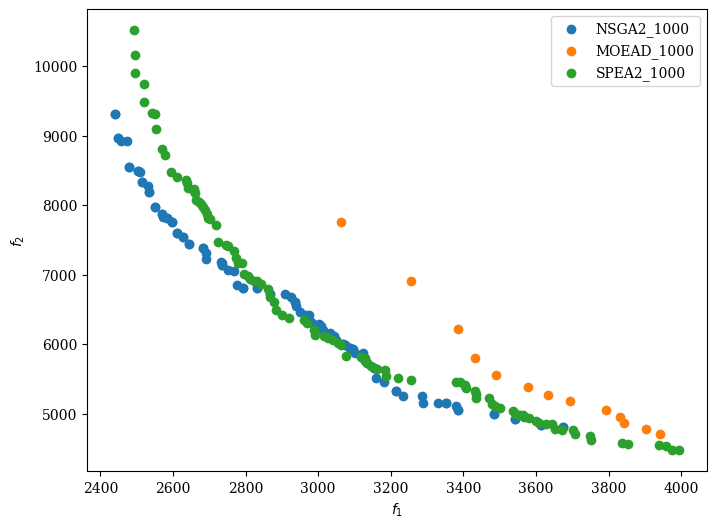

In [77]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(pareto_moead, label="MOEAD_1000")
scatter.add(pareto_spea2, label="SPEA2_1000")
scatter.legend=True
scatter.show()

In [79]:
def inicializar_poblacion(n_cities, n_individuals):
    """
    Inicializa la población con valores continuos en [0, 1].
    Cada fila será un individuo de longitud `n_cities`.
    """
    return np.random.rand(n_individuals, n_cities)


In [80]:
def evaluar_poblacion(problem, poblacion):
    """
    Evalúa una población en términos de los objetivos multiobjetivo definidos en TSPProblem.
    
    Parameters:
    - problem: Instancia del problema TSPProblem (definido con Pymoo).
    - poblacion: Lista de individuos (rutas) a evaluar.
    
    Returns:
    - valores_objetivo: Una lista de tuplas donde cada tupla representa (distancia, tiempo) para un individuo.
    """
    x = np.array(poblacion)
    resultados = {}
    problem._evaluate(x, resultados)
    valores_objetivo = resultados["F"]
    return valores_objetivo


In [81]:
def calcular_crowding_distance(valores_objetivo):
    """
    Calcula la distancia de hacinamiento (crowding distance) para un conjunto de objetivos.
    
    Parameters:
    - valores_objetivo: Matriz de objetivos (N x M).
    
    Returns:
    - crowding: Array con la distancia de hacinamiento para cada solución.
    """
    n_ind, n_obj = valores_objetivo.shape
    crowding = np.zeros(n_ind)

    # Para cada objetivo, calcular la distancia crowding
    for m in range(n_obj):
        # Ordenar por el m-ésimo objetivo
        sorted_indices = np.argsort(valores_objetivo[:, m])
        sorted_obj = valores_objetivo[sorted_indices, m]

        # Asignar infinito a los extremos (frontera del rango)
        crowding[sorted_indices[0]] = np.inf
        crowding[sorted_indices[-1]] = np.inf

        # Calcular la distancia normalizada para los intermedios
        norm = sorted_obj[-1] - sorted_obj[0]
        if norm > 0:
            for i in range(1, n_ind - 1):
                crowding[sorted_indices[i]] += (
                    (sorted_obj[i + 1] - sorted_obj[i - 1]) / norm
                )

    return crowding

In [82]:
def seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=2):
    """
    Realiza la selección por torneo para problemas multiobjetivo utilizando Pymoo.
    
    Parameters:
    - poblacion: Lista de individuos.
    - valores_objetivo: Matriz de valores objetivo (N x M).
    - n_individuals: Número de individuos a seleccionar.
    - T: Tamaño del torneo (default: 6).
    
    Returns:
    - padres: Lista de individuos seleccionados.
    """
    padres = []

    # Realizar torneo para seleccionar cada padre
    for _ in range(n_individuals):
        # Seleccionar T competidores al azar
        indices = np.random.choice(len(poblacion), size=T, replace=False)
        competidores = [poblacion[i] for i in indices]
        objetivos_competidores = valores_objetivo[indices]

        # Identificar los no dominados usando Pymoo
        nds = NonDominatedSorting()
        frentes = nds.do(objetivos_competidores, only_non_dominated_front=True)
        no_dominados = np.atleast_1d(frentes[0])  # Convertir siempre a array de al menos 1D

        if len(no_dominados) == 1:
            # Si hay un único no dominado, seleccionarlo
            ganador = competidores[no_dominados[0]]
        else:
            # Si hay empate, calcular distancia crowding
            crowding = calcular_crowding_distance(objetivos_competidores)
            idx_mejor = no_dominados[np.argmax(crowding[no_dominados])]
            ganador = competidores[idx_mejor]

        padres.append(ganador)

    return padres


In [83]:
def arithmetic_crossover(parent1, parent2, pcross):
    """
    Realiza un cruce aritmético simple con probabilidad pcross.
    parent1 y parent2 son arrays 1D de valores en [0,1].
    """
    # Si no se hace cruce, devolvemos copias
    if np.random.rand() >= pcross:
        return np.copy(parent1), np.copy(parent2)

    # Mezclamos con un factor alpha en [0,1]
    alpha = np.random.rand()
    
    # Hijo1: alpha * p1 + (1-alpha) * p2
    # Hijo2: alpha * p2 + (1-alpha) * p1
    child1 = alpha * parent1 + (1 - alpha) * parent2
    child2 = alpha * parent2 + (1 - alpha) * parent1

    # Nos aseguramos de seguir en [0,1]
    child1 = np.clip(child1, 0, 1)
    child2 = np.clip(child2, 0, 1)

    return child1, child2


In [84]:
def mutate_uniform(ind, pmut):
    """
    Mutación uniforme: cada gen tiene probabilidad pmut de ser reemplazado
    por un valor aleatorio en [0,1].
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            ind[i] = np.random.rand()
    return ind

def mutate_gaussian(ind, pmut, sigma=0.1):
    """
    Mutación gaussiana: con probabilidad pmut, se le suma
    una perturbación normal(0, sigma).
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            # pequeña perturbación
            perturb = np.random.normal(0, sigma)
            ind[i] += perturb
            # recortamos a [0,1]
            ind[i] = np.clip(ind[i], 0, 1)
    return ind


mutations = [mutate_uniform, mutate_gaussian]

def mutate(ind, pmut):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.

    Parameters:
    - ind: Individuo a mutar.
    - pmut: Probabilidad de mutación.

    Returns:
    - Individuo mutado.
    """
    mutation_operator = np.random.choice(mutations)
    return mutation_operator(ind, pmut)

In [85]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):

    # 1. Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    # 2. Evaluar
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()

    for gen in range(1, n_generations + 1):

        # 3. Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            # padres ya son vectores continuos
            padre1, padre2 = random.sample(padres, 2)

            # 4. Cruce real-coded
            hijo1, hijo2 = arithmetic_crossover(padre1, padre2, pcross)

            # 5. Mutación real-coded
            hijo1 = mutate(hijo1, pmut)  # p.ej. mutate_uniform
            hijo2 = mutate(hijo2, pmut)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            print(f"Generación {gen}: {len(nd_front)} soluciones no dominadas.")

    # Retornar
    return poblacion, valores_objetivo


#### Función para ejecutar algoritmo 10 veces y guardar resultados y métricas

In [86]:
def multiple_experiments_with_metrics(problem, n_generations, n_individuals, pcross, pmut, trace=250, T=6, num_experiments=10):
    """
    Ejecuta el método `evolve` múltiples veces y recoge las métricas de cada ejecución.

    @param problem: Problema multiobjetivo.
    @param n_generations: Número de generaciones.
    @param n_individuals: Tamaño de la población.
    @param pcross: Probabilidad de cruce.
    @param pmut: Probabilidad de mutación.
    @param trace: Intervalo de impresión de progreso.
    @param T: Tamaño del torneo de selección.
    @param num_experiments: Número de experimentos a realizar.

    @return: Resumen de métricas y el mejor frente de Pareto encontrado.
    """
    metrics_summary = []
    best_hypervolume = -float('inf')
    pareto_nsga2 = None

    for i in range(num_experiments):
        print(f"\nEjecución {i+1}/{num_experiments}:")

        # Ejecutar `evolve`
        _, valores_objetivo = evolve(
            problem=problem,
            n_generations=n_generations,
            n_individuals=n_individuals,
            pcross=pcross,
            pmut=pmut,
            trace=trace,
            T=T
        )

        # Obtener el frente no dominado
        nd_sort = NonDominatedSorting()
        nd_front_indices = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front = valores_objetivo[nd_front_indices]

        # Calcular métricas
        hv, spr, spa = calculate_metrics(front)
        metrics_summary.append((hv, spr, spa))

        print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # Guardar el mejor frente según el hipervolumen
        if hv > best_hypervolume:
            best_hypervolume = hv
            pareto_nsga2 = front

    # Calcular promedios y desviaciones estándar
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return pareto_nsga2, metrics_summary

In [87]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=1/100, 
                                                                                   trace=250, 
                                                                                   T=6, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 7 soluciones no dominadas.
Generación 250: 3 soluciones no dominadas.
Generación 500: 4 soluciones no dominadas.
Generación 750: 3 soluciones no dominadas.
Generación 1000: 6 soluciones no dominadas.
Hipervolumen: 13271554.8429, Dispersión (SPR): 647.4748, Espaciado (SPA): 137.1998

Ejecución 2/10:
Generación 1: 7 soluciones no dominadas.
Generación 250: 1 soluciones no dominadas.
Generación 500: 7 soluciones no dominadas.
Generación 750: 4 soluciones no dominadas.
Generación 1000: 8 soluciones no dominadas.
Hipervolumen: 12424073.0797, Dispersión (SPR): 640.3552, Espaciado (SPA): 72.4283

Ejecución 3/10:
Generación 1: 12 soluciones no dominadas.
Generación 250: 5 soluciones no dominadas.
Generación 500: 13 soluciones no dominadas.
Generación 750: 4 soluciones no dominadas.
Generación 1000: 7 soluciones no dominadas.
Hipervolumen: 13148695.8144, Dispersión (SPR): 1324.1413, Espaciado (SPA): 175.9790

Ejecución 4/10:
Generación 1: 5 soluciones no dominadas

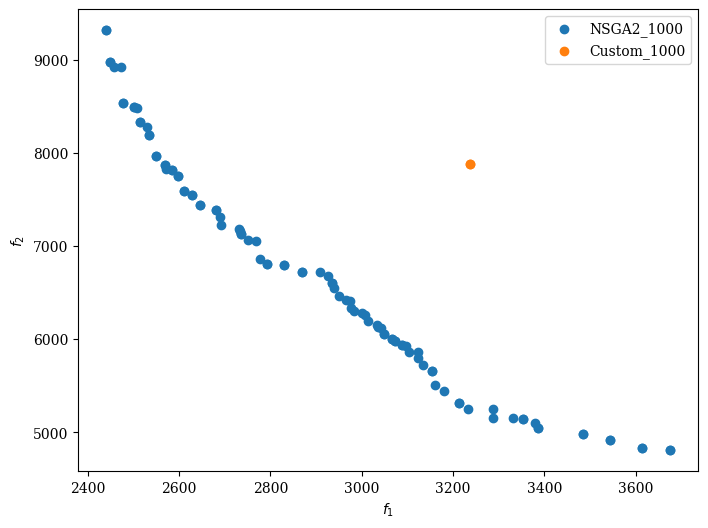

In [88]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [89]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=1/100, 
                                                                                   trace=250, 
                                                                                   T=10, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 7 soluciones no dominadas.
Generación 250: 11 soluciones no dominadas.
Generación 500: 11 soluciones no dominadas.
Generación 750: 20 soluciones no dominadas.
Generación 1000: 29 soluciones no dominadas.
Hipervolumen: 23068332.0748, Dispersión (SPR): 925.5348, Espaciado (SPA): 27.6139

Ejecución 2/10:
Generación 1: 10 soluciones no dominadas.
Generación 250: 4 soluciones no dominadas.
Generación 500: 16 soluciones no dominadas.
Generación 750: 6 soluciones no dominadas.
Generación 1000: 29 soluciones no dominadas.
Hipervolumen: 21837434.6217, Dispersión (SPR): 384.9541, Espaciado (SPA): 5.2236

Ejecución 3/10:
Generación 1: 4 soluciones no dominadas.
Generación 250: 9 soluciones no dominadas.
Generación 500: 5 soluciones no dominadas.
Generación 750: 19 soluciones no dominadas.
Generación 1000: 39 soluciones no dominadas.
Hipervolumen: 20372457.9536, Dispersión (SPR): 276.6433, Espaciado (SPA): 8.6178

Ejecución 4/10:
Generación 1: 4 soluciones no dominad

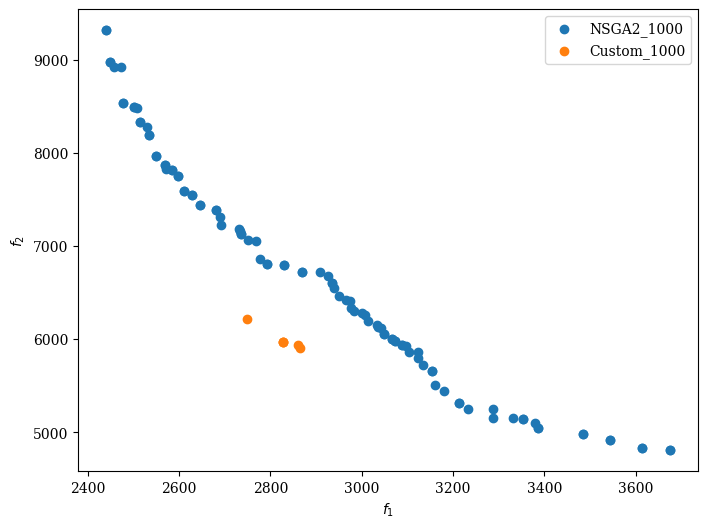

In [90]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [91]:
def sbx_crossover(parent1, parent2, pc=0.9, eta_c=15):
    """
    Simulated Binary Crossover (SBX) para variables continuas en [0,1].
    parent1 y parent2 son arrays 1D (mismo tamaño).
    
    pc: probabilidad de cruce.
    eta_c: distribution index, controla la 'intensidad' del cruce.
    
    Devuelve (child1, child2) como arrays.
    """
    # Si no ocurre cruce, retornamos copias
    if np.random.rand() >= pc:
        return np.copy(parent1), np.copy(parent2)

    n_var = len(parent1)
    child1 = np.zeros(n_var)
    child2 = np.zeros(n_var)

    for i in range(n_var):
        x1 = parent1[i]
        x2 = parent2[i]

        # Asegurarse de que x1 <= x2
        if x1 > x2:
            x1, x2 = x2, x1

        if abs(x1 - x2) < 1e-14:
            # Si son prácticamente iguales, copiamos
            child1[i] = x1
            child2[i] = x2
        else:
            # Beta determina el 'gradio' de cruce
            rand = np.random.rand()
            beta = 1.0 + (2.0 * (x1 - 0.0) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta_c + 1.0))
            if rand <= 1.0 / alpha:
                betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

            c1 = 0.5 * ((x1 + x2) - betaq * (x2 - x1))

            beta = 1.0 + (2.0 * (1.0 - x2) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta_c + 1.0))
            if rand <= 1.0 / alpha:
                betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

            c2 = 0.5 * ((x1 + x2) + betaq * (x2 - x1))

            # Recortar a [0,1]
            c1 = min(max(c1, 0.0), 1.0)
            c2 = min(max(c2, 0.0), 1.0)

            # Aleatoriamente asignamos quién obtiene c1 y c2
            if np.random.rand() < 0.5:
                child1[i] = c2
                child2[i] = c1
            else:
                child1[i] = c1
                child2[i] = c2

    return child1, child2

In [92]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):

    # 1. Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    # 2. Evaluar
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()

    for gen in range(1, n_generations + 1):

        # 3. Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            # padres ya son vectores continuos
            padre1, padre2 = random.sample(padres, 2)

            # 4. Cruce real-coded
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)

            # 5. Mutación real-coded
            hijo1 = mutate(hijo1, pmut)  # p.ej. mutate_uniform
            hijo2 = mutate(hijo2, pmut)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            print(f"Generación {gen}: {len(nd_front)} soluciones no dominadas.")

    # Retornar
    return poblacion, valores_objetivo


In [93]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=1/100, 
                                                                                   trace=250, 
                                                                                   T=10, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 2 soluciones no dominadas.
Generación 250: 15 soluciones no dominadas.
Generación 500: 14 soluciones no dominadas.
Generación 750: 11 soluciones no dominadas.
Generación 1000: 18 soluciones no dominadas.
Hipervolumen: 21743808.3356, Dispersión (SPR): 964.7910, Espaciado (SPA): 38.3792

Ejecución 2/10:
Generación 1: 2 soluciones no dominadas.
Generación 250: 7 soluciones no dominadas.
Generación 500: 21 soluciones no dominadas.
Generación 750: 9 soluciones no dominadas.
Generación 1000: 31 soluciones no dominadas.
Hipervolumen: 25134089.4304, Dispersión (SPR): 935.4836, Espaciado (SPA): 9.6349

Ejecución 3/10:
Generación 1: 5 soluciones no dominadas.
Generación 250: 26 soluciones no dominadas.
Generación 500: 10 soluciones no dominadas.
Generación 750: 18 soluciones no dominadas.
Generación 1000: 16 soluciones no dominadas.
Hipervolumen: 23266418.0245, Dispersión (SPR): 686.9727, Espaciado (SPA): 5.2327

Ejecución 4/10:
Generación 1: 8 soluciones no domina

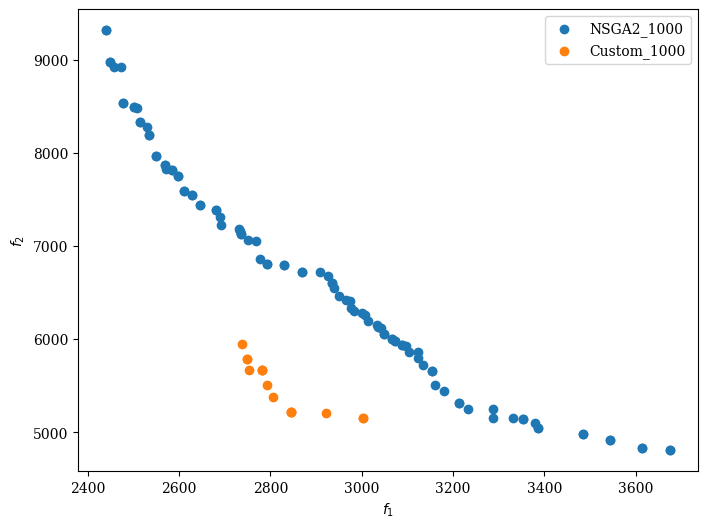

In [94]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [95]:
def blx_crossover(parent1, parent2, pc=0.9, alpha=0.5):
    """
    BLX-alpha crossover para variables continuas en [0,1].
    
    pc: prob. de cruce.
    alpha: factor de mezclado (0.5 suele ser un valor estándar).
    """
    if np.random.rand() >= pc:
        return np.copy(parent1), np.copy(parent2)
    
    n_var = len(parent1)
    child1 = np.zeros(n_var)
    child2 = np.zeros(n_var)

    for i in range(n_var):
        x1 = parent1[i]
        x2 = parent2[i]
        cmin = min(x1, x2)
        cmax = max(x1, x2)
        diff = cmax - cmin
        lower = cmin - alpha * diff
        upper = cmax + alpha * diff

        # Generar valores aleatorios en [lower, upper]
        val1 = np.random.uniform(lower, upper)
        val2 = np.random.uniform(lower, upper)

        # Recortar a [0,1]
        child1[i] = max(0.0, min(1.0, val1))
        child2[i] = max(0.0, min(1.0, val2))
    
    return child1, child2

In [96]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):

    # 1. Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    # 2. Evaluar
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()

    for gen in range(1, n_generations + 1):

        # 3. Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            # padres ya son vectores continuos
            padre1, padre2 = random.sample(padres, 2)

            # 4. Cruce real-coded
            hijo1, hijo2 = blx_crossover(padre1, padre2, pcross, 0.5)

            # 5. Mutación real-coded
            hijo1 = mutate(hijo1, pmut)  # p.ej. mutate_uniform
            hijo2 = mutate(hijo2, pmut)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            print(f"Generación {gen}: {len(nd_front)} soluciones no dominadas.")

    # Retornar
    return poblacion, valores_objetivo

In [97]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=1/100, 
                                                                                   trace=250, 
                                                                                   T=10, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 12 soluciones no dominadas.
Generación 500: 3 soluciones no dominadas.
Generación 750: 9 soluciones no dominadas.
Generación 1000: 12 soluciones no dominadas.
Hipervolumen: 21668816.5466, Dispersión (SPR): 273.2579, Espaciado (SPA): 0.0000

Ejecución 2/10:
Generación 1: 4 soluciones no dominadas.
Generación 250: 11 soluciones no dominadas.
Generación 500: 15 soluciones no dominadas.
Generación 750: 6 soluciones no dominadas.
Generación 1000: 7 soluciones no dominadas.
Hipervolumen: 18242198.2303, Dispersión (SPR): 1234.7391, Espaciado (SPA): 131.3031

Ejecución 3/10:
Generación 1: 5 soluciones no dominadas.
Generación 250: 7 soluciones no dominadas.
Generación 500: 10 soluciones no dominadas.
Generación 750: 9 soluciones no dominadas.
Generación 1000: 22 soluciones no dominadas.
Hipervolumen: 23724481.4218, Dispersión (SPR): 703.6176, Espaciado (SPA): 20.2649

Ejecución 4/10:
Generación 1: 4 soluciones no dominad

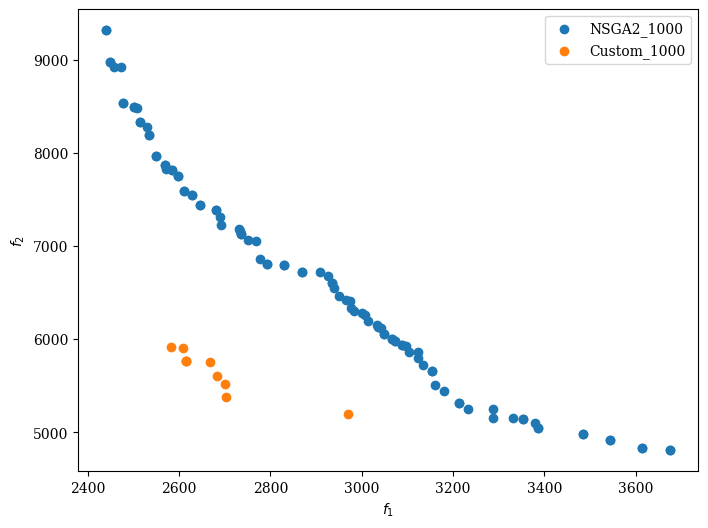

In [98]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

El cruce SBX da mejores resultados (en 10 ejecuciones) que el cruce BLX

In [99]:
def polynomial_mutation(child, pm=0.1, eta_m=20):
    """
    Polynomial Mutation para variables continuas en [0,1].
    child: array 1D.
    
    pm: prob. de mutación por gen.
    eta_m: distribution index para la mutación.
    
    Devuelve el mismo array 'child' mutado in-place.
    """
    n_var = len(child)

    for i in range(n_var):
        if np.random.rand() < pm:
            x = child[i]
            if x < 1e-14:
                x = 0.0
            elif x > 1.0 - 1e-14:
                x = 1.0

            delta1 = (x - 0.0) / (1.0 - 0.0)
            delta2 = (1.0 - x) / (1.0 - 0.0)
            rand = np.random.rand()
            mut_pow = 1.0 / (eta_m + 1.0)

            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta_m + 1.0))
                deltaq = (val ** mut_pow) - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta_m + 1.0))
                deltaq = 1.0 - (val ** mut_pow)

            x = x + deltaq
            x = min(max(x, 0.0), 1.0)
            child[i] = x

    return child

In [100]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):

    # 1. Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    # 2. Evaluar
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()

    for gen in range(1, n_generations + 1):

        # 3. Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            # padres ya son vectores continuos
            padre1, padre2 = random.sample(padres, 2)

            # 4. Cruce real-coded
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)

            # 5. Mutación real-coded
            hijo1 = polynomial_mutation(hijo1, pmut, 20)  # p.ej. mutate_uniform
            hijo2 = polynomial_mutation(hijo2, pmut, 20)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            print(f"Generación {gen}: {len(nd_front)} soluciones no dominadas.")

    # Retornar
    return poblacion, valores_objetivo


In [101]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=1/100, 
                                                                                   trace=250, 
                                                                                   T=10, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 4 soluciones no dominadas.
Generación 250: 12 soluciones no dominadas.
Generación 500: 22 soluciones no dominadas.
Generación 750: 26 soluciones no dominadas.
Generación 1000: 31 soluciones no dominadas.
Hipervolumen: 20848378.6947, Dispersión (SPR): 590.3895, Espaciado (SPA): 11.8300

Ejecución 2/10:
Generación 1: 8 soluciones no dominadas.
Generación 250: 7 soluciones no dominadas.
Generación 500: 28 soluciones no dominadas.
Generación 750: 19 soluciones no dominadas.
Generación 1000: 27 soluciones no dominadas.
Hipervolumen: 22337274.4468, Dispersión (SPR): 945.9191, Espaciado (SPA): 15.1099

Ejecución 3/10:
Generación 1: 9 soluciones no dominadas.
Generación 250: 7 soluciones no dominadas.
Generación 500: 33 soluciones no dominadas.
Generación 750: 22 soluciones no dominadas.
Generación 1000: 32 soluciones no dominadas.
Hipervolumen: 21315510.5550, Dispersión (SPR): 1155.6227, Espaciado (SPA): 21.2466

Ejecución 4/10:
Generación 1: 6 soluciones no dom

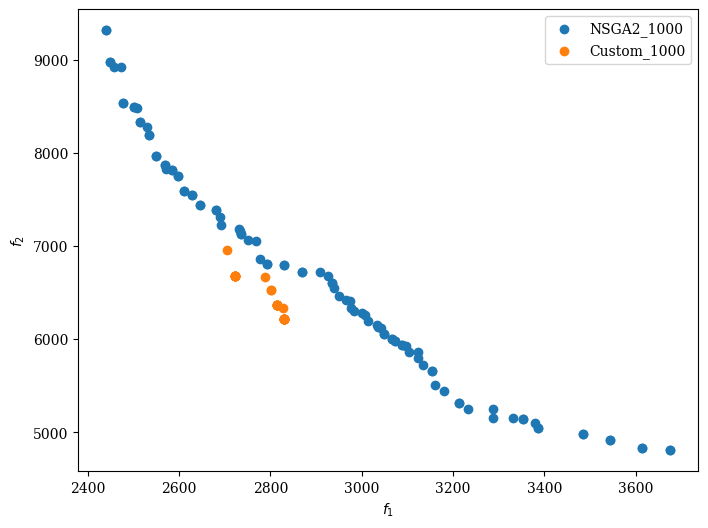

In [102]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [103]:
def polynomial_mutation(child, pm=0.1, eta_m=20):
    """
    Polynomial Mutation para variables continuas en [0,1].
    child: array 1D.
    
    pm: prob. de mutación por gen.
    eta_m: distribution index para la mutación.
    
    Devuelve el mismo array 'child' mutado in-place.
    """
    n_var = len(child)

    for i in range(n_var):
        if np.random.rand() < pm:
            x = child[i]
            if x < 1e-14:
                x = 0.0
            elif x > 1.0 - 1e-14:
                x = 1.0

            delta1 = (x - 0.0) / (1.0 - 0.0)
            delta2 = (1.0 - x) / (1.0 - 0.0)
            rand = np.random.rand()
            mut_pow = 1.0 / (eta_m + 1.0)

            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta_m + 1.0))
                deltaq = (val ** mut_pow) - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta_m + 1.0))
                deltaq = 1.0 - (val ** mut_pow)

            x = x + deltaq
            x = min(max(x, 0.0), 1.0)
            child[i] = x

    return child

def mutate_uniform(ind, pmut):
    """
    Mutación uniforme: cada gen tiene probabilidad pmut de ser reemplazado
    por un valor aleatorio en [0,1].
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            ind[i] = np.random.rand()
    return ind

def mutate_gaussian(ind, pmut, sigma=0.1):
    """
    Mutación gaussiana: con probabilidad pmut, se le suma
    una perturbación normal(0, sigma).
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            # pequeña perturbación
            perturb = np.random.normal(0, sigma)
            ind[i] += perturb
            # recortamos a [0,1]
            ind[i] = np.clip(ind[i], 0, 1)
    return ind


mutations = [mutate_uniform, mutate_gaussian, polynomial_mutation]

def mutate(ind, pmut):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.

    Parameters:
    - ind: Individuo a mutar.
    - pmut: Probabilidad de mutación.

    Returns:
    - Individuo mutado.
    """
    mutation_operator = np.random.choice(mutations)
    return mutation_operator(ind, pmut)

In [104]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):

    # 1. Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    # 2. Evaluar
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()

    for gen in range(1, n_generations + 1):

        # 3. Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            # padres ya son vectores continuos
            padre1, padre2 = random.sample(padres, 2)

            # 4. Cruce real-coded
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)

            # 5. Mutación real-coded
            hijo1 = mutate(hijo1, pmut)  # p.ej. mutate_uniform
            hijo2 = mutate(hijo2, pmut)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            print(f"Generación {gen}: {len(nd_front)} soluciones no dominadas.")

    # Retornar
    return poblacion, valores_objetivo

In [105]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=1/100, 
                                                                                   trace=250, 
                                                                                   T=10, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 5 soluciones no dominadas.
Generación 250: 21 soluciones no dominadas.
Generación 500: 36 soluciones no dominadas.
Generación 750: 18 soluciones no dominadas.
Generación 1000: 20 soluciones no dominadas.
Hipervolumen: 24158048.0263, Dispersión (SPR): 780.7604, Espaciado (SPA): 22.9388

Ejecución 2/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 15 soluciones no dominadas.
Generación 500: 24 soluciones no dominadas.
Generación 750: 35 soluciones no dominadas.
Generación 1000: 32 soluciones no dominadas.
Hipervolumen: 23842097.2207, Dispersión (SPR): 1567.0759, Espaciado (SPA): 39.5667

Ejecución 3/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 11 soluciones no dominadas.
Generación 500: 28 soluciones no dominadas.
Generación 750: 28 soluciones no dominadas.
Generación 1000: 43 soluciones no dominadas.
Hipervolumen: 23996821.0811, Dispersión (SPR): 585.9138, Espaciado (SPA): 3.3018

Ejecución 4/10:
Generación 1: 10 soluciones no d

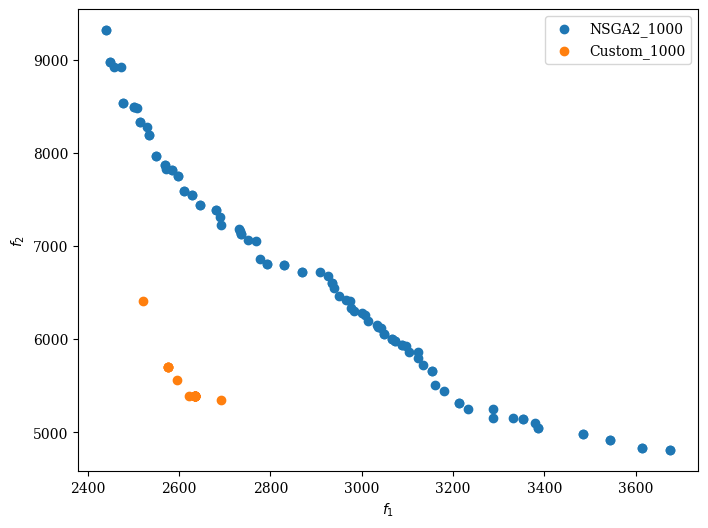

In [106]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

Los tres tipos de mutación juntos da mejores resultados que uno solo.

In [107]:
from pymoo.util.dominator import Dominator
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def mantener_no_dominadas_diversas(poblacion, valores_objetivo, max_size):
    nd_sort = NonDominatedSorting()
    nd_front_indices = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
    no_dominadas = [poblacion[i] for i in nd_front_indices]
    objetivos_no_dominadas = valores_objetivo[nd_front_indices]

    if len(no_dominadas) > max_size:
        # Calcular crowding distance y seleccionar los más diversos
        crowding_distances = calcular_crowding_distance(objetivos_no_dominadas)
        selected_indices = np.argsort(crowding_distances)[-max_size:]  # Seleccionar los más diversos
        no_dominadas = [no_dominadas[i] for i in selected_indices]

    return no_dominadas


def calcular_crowding_distance(valores_objetivo):
    n, m = valores_objetivo.shape
    crowding = np.zeros(n)
    for i in range(m):
        sorted_indices = np.argsort(valores_objetivo[:, i])
        sorted_obj = valores_objetivo[sorted_indices, i]
        crowding[sorted_indices[0]] = np.inf
        crowding[sorted_indices[-1]] = np.inf
        for j in range(1, n - 1):
            crowding[sorted_indices[j]] += (sorted_obj[j + 1] - sorted_obj[j - 1])
    return crowding


In [108]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2, elitism=True):

    # 1. Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    # 2. Evaluar
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()

    for gen in range(1, n_generations + 1):

        # 3. Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            # padres ya son vectores continuos
            padre1, padre2 = random.sample(padres, 2)

            # 4. Cruce real-coded
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)

            # 5. Mutación real-coded
            hijo1 = mutate(hijo1, pmut)  # p.ej. mutate_uniform
            hijo2 = mutate(hijo2, pmut)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        # 6. Evaluar la nueva población
        #valores_objetivo_nueva = evaluar_poblacion(problem, nueva_poblacion)

        # 7. Aplicar elitismo si está activado
        if elitism:
            no_dominadas = mantener_no_dominadas_diversas(poblacion, valores_objetivo, max_size=n_individuals // 2)
            nueva_poblacion = no_dominadas + nueva_poblacion
            nueva_poblacion = nueva_poblacion[:n_individuals]


        # Actualizar la población y los valores objetivo
        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            print(f"Generación {gen}: {len(nd_front)} soluciones no dominadas.")

    # Retornar
    return poblacion, valores_objetivo

In [109]:
def multiple_experiments_with_metrics(problem, n_generations, n_individuals, pcross, pmut, trace=250, T=6, elitism=True, num_experiments=10):
    """
    Ejecuta el método `evolve` múltiples veces y recoge las métricas de cada ejecución.

    @param problem: Problema multiobjetivo.
    @param n_generations: Número de generaciones.
    @param n_individuals: Tamaño de la población.
    @param pcross: Probabilidad de cruce.
    @param pmut: Probabilidad de mutación.
    @param trace: Intervalo de impresión de progreso.
    @param T: Tamaño del torneo de selección.
    @param num_experiments: Número de experimentos a realizar.

    @return: Resumen de métricas y el mejor frente de Pareto encontrado.
    """
    metrics_summary = []
    best_hypervolume = -float('inf')
    pareto_nsga2 = None

    for i in range(num_experiments):
        print(f"\nEjecución {i+1}/{num_experiments}:")

        # Ejecutar `evolve`
        _, valores_objetivo = evolve(
            problem=problem,
            n_generations=n_generations,
            n_individuals=n_individuals,
            pcross=pcross,
            pmut=pmut,
            trace=trace,
            T=T,
            elitism=True
        )

        # Obtener el frente no dominado
        nd_sort = NonDominatedSorting()
        nd_front_indices = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front = valores_objetivo[nd_front_indices]

        # Calcular métricas
        hv, spr, spa = calculate_metrics(front)
        metrics_summary.append((hv, spr, spa))

        print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # Guardar el mejor frente según el hipervolumen
        if hv > best_hypervolume:
            best_hypervolume = hv
            pareto_nsga2 = front

    # Calcular promedios y desviaciones estándar
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return pareto_nsga2, metrics_summary

In [110]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=0.01, 
                                                                                   trace=250, 
                                                                                   T=6,
                                                                                   elitism=True, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 11 soluciones no dominadas.
Generación 250: 56 soluciones no dominadas.
Generación 500: 49 soluciones no dominadas.
Generación 750: 56 soluciones no dominadas.
Generación 1000: 55 soluciones no dominadas.
Hipervolumen: 23938671.8119, Dispersión (SPR): 5563.1749, Espaciado (SPA): 25.5476

Ejecución 2/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 29 soluciones no dominadas.
Generación 500: 53 soluciones no dominadas.
Generación 750: 53 soluciones no dominadas.
Generación 1000: 53 soluciones no dominadas.
Hipervolumen: 25278020.6571, Dispersión (SPR): 5362.3961, Espaciado (SPA): 29.6771

Ejecución 3/10:
Generación 1: 7 soluciones no dominadas.
Generación 250: 47 soluciones no dominadas.
Generación 500: 45 soluciones no dominadas.
Generación 750: 59 soluciones no dominadas.
Generación 1000: 56 soluciones no dominadas.
Hipervolumen: 24910544.3019, Dispersión (SPR): 3115.4280, Espaciado (SPA): 11.0980

Ejecución 4/10:
Generación 1: 14 soluciones 

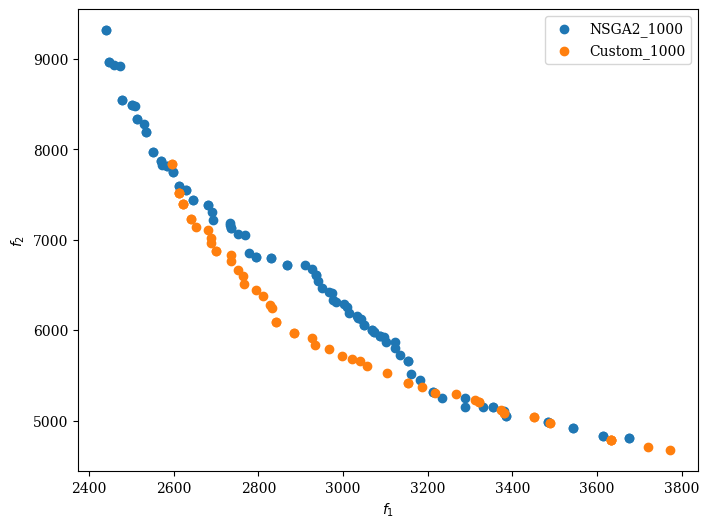

In [111]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [112]:
def mantener_extremos(poblacion, valores_objetivo):
    """
    Retorna las soluciones con los mejores valores individuales en cada objetivo.
    """
    extremos_indices = np.argmin(valores_objetivo, axis=0)
    soluciones_extremas = [poblacion[extremos_indices[0]], poblacion[extremos_indices[1]]]
    return soluciones_extremas

def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2, elitism=True):
    # Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()
    prev_front_size = 0  # Variable para guardar el tamaño del frente anterior

    for gen in range(1, n_generations + 1):
        # Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        # **Añadir siempre los extremos**
        extremos = mantener_extremos(poblacion, valores_objetivo)
        padres.extend(extremos)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            padre1, padre2 = random.sample(padres, 2)
            # Cruce real-coded
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)
            # Mutación adaptativa
            hijo1 = mutate(hijo1, pmut)
            hijo2 = mutate(hijo2, pmut)
            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        valores_objetivo_nueva = evaluar_poblacion(problem, nueva_poblacion)

        # **Reinicialización parcial de la población cada 200 generaciones**
        if gen % 200 == 0:
            n_reinit = int(0.1 * n_individuals)
            nuevos_individuos = inicializar_poblacion(problem.n_var, n_reinit)
            valores_objetivo_nuevos = evaluar_poblacion(problem, nuevos_individuos)
            nueva_poblacion[:n_reinit] = nuevos_individuos
            valores_objetivo_nueva[:n_reinit] = valores_objetivo_nuevos

        # Elitismo: mantener las mejores soluciones no dominadas
        if elitism:
            no_dominadas = mantener_no_dominadas_diversas(poblacion, valores_objetivo, max_size=n_individuals // 2)
            nueva_poblacion = no_dominadas + nueva_poblacion
            nueva_poblacion = nueva_poblacion[:n_individuals]

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # **Mutación adaptativa**: aumenta si no hay mejoras en el frente
        nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front_size = len(nd_front)  # Tamaño del frente actual
        if gen > 100 and front_size == prev_front_size:
            pmut = min(pmut * 1.5, 0.5)
        else:
            pmut = max(pmut / 1.5, 1 / problem.n_var)
        prev_front_size = front_size

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            print(f"Generación {gen}: {front_size} soluciones no dominadas.")

    # Retornar la última población y los valores objetivo
    return poblacion, valores_objetivo


In [113]:
def multiple_experiments_with_metrics(problem, n_generations, n_individuals, pcross, pmut, trace=250, T=10, elitism=True, num_experiments=10):
    """
    Ejecuta el método `evolve` múltiples veces y recoge las métricas de cada ejecución.

    @param problem: Problema multiobjetivo.
    @param n_generations: Número de generaciones.
    @param n_individuals: Tamaño de la población.
    @param pcross: Probabilidad de cruce.
    @param pmut: Probabilidad de mutación.
    @param trace: Intervalo de impresión de progreso.
    @param T: Tamaño del torneo de selección.
    @param num_experiments: Número de experimentos a realizar.

    @return: Resumen de métricas y el mejor frente de Pareto encontrado.
    """
    metrics_summary = []
    best_hypervolume = -float('inf')
    pareto_nsga2 = None

    for i in range(num_experiments):
        print(f"\nEjecución {i+1}/{num_experiments}:")

        # Ejecutar `evolve`
        _, valores_objetivo = evolve(
            problem=problem,
            n_generations=n_generations,
            n_individuals=n_individuals,
            pcross=pcross,
            pmut=pmut,
            trace=trace,
            T=T,
            elitism=True
        )

        # Obtener el frente no dominado
        nd_sort = NonDominatedSorting()
        nd_front_indices = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front = valores_objetivo[nd_front_indices]

        # Calcular métricas
        hv, spr, spa = calculate_metrics(front)
        metrics_summary.append((hv, spr, spa))

        print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # Guardar el mejor frente según el hipervolumen
        if hv > best_hypervolume:
            best_hypervolume = hv
            pareto_nsga2 = front

    # Calcular promedios y desviaciones estándar
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return pareto_nsga2, metrics_summary

In [114]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=0.01, 
                                                                                   trace=250, 
                                                                                   T=10,
                                                                                   elitism=True, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 55 soluciones no dominadas.
Generación 500: 50 soluciones no dominadas.
Generación 750: 50 soluciones no dominadas.
Generación 1000: 54 soluciones no dominadas.
Hipervolumen: 21024483.6118, Dispersión (SPR): 4052.0416, Espaciado (SPA): 21.8556

Ejecución 2/10:
Generación 1: 8 soluciones no dominadas.
Generación 250: 48 soluciones no dominadas.
Generación 500: 55 soluciones no dominadas.
Generación 750: 60 soluciones no dominadas.
Generación 1000: 53 soluciones no dominadas.
Hipervolumen: 23464742.7666, Dispersión (SPR): 4138.8758, Espaciado (SPA): 23.1120

Ejecución 3/10:
Generación 1: 13 soluciones no dominadas.
Generación 250: 52 soluciones no dominadas.
Generación 500: 53 soluciones no dominadas.
Generación 750: 56 soluciones no dominadas.
Generación 1000: 56 soluciones no dominadas.
Hipervolumen: 24261516.5433, Dispersión (SPR): 5799.9440, Espaciado (SPA): 14.1079

Ejecución 4/10:
Generación 1: 5 soluciones n

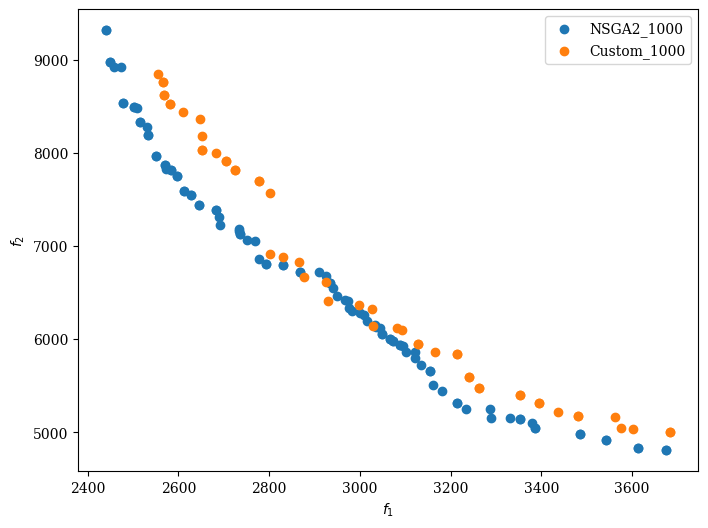

In [115]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [116]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=1, 
                                                                                   pmut=0.01, 
                                                                                   trace=250, 
                                                                                   T=10,
                                                                                   elitism=True, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 7 soluciones no dominadas.
Generación 250: 32 soluciones no dominadas.
Generación 500: 49 soluciones no dominadas.
Generación 750: 49 soluciones no dominadas.
Generación 1000: 49 soluciones no dominadas.
Hipervolumen: 20627753.6650, Dispersión (SPR): 2561.4441, Espaciado (SPA): 29.2995

Ejecución 2/10:
Generación 1: 12 soluciones no dominadas.
Generación 250: 19 soluciones no dominadas.
Generación 500: 19 soluciones no dominadas.
Generación 750: 19 soluciones no dominadas.
Generación 1000: 19 soluciones no dominadas.
Hipervolumen: 16750385.5608, Dispersión (SPR): 2687.7597, Espaciado (SPA): 69.1606

Ejecución 3/10:
Generación 1: 7 soluciones no dominadas.
Generación 250: 22 soluciones no dominadas.
Generación 500: 54 soluciones no dominadas.
Generación 750: 50 soluciones no dominadas.
Generación 1000: 50 soluciones no dominadas.
Hipervolumen: 22490256.8336, Dispersión (SPR): 4313.1340, Espaciado (SPA): 35.9048

Ejecución 4/10:
Generación 1: 8 soluciones n

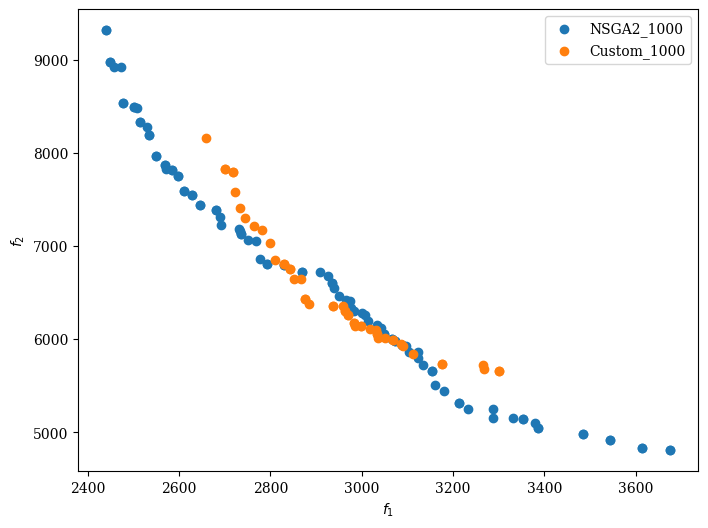

In [117]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [118]:
def mutate_adaptive_gaussian(ind, pmut, gen, max_gen):
    sigma = 0.5 * (1 - gen / max_gen)  # Reducción de la desviación estándar con el número de generaciones
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            perturb = np.random.normal(0, sigma)
            ind[i] += perturb
            ind[i] = np.clip(ind[i], 0, 1)
    return ind

In [119]:
def mantener_extremos(poblacion, valores_objetivo):
    """
    Retorna las soluciones con los mejores valores individuales en cada objetivo.
    """
    extremos_indices = np.argmin(valores_objetivo, axis=0)
    soluciones_extremas = [poblacion[extremos_indices[0]], poblacion[extremos_indices[1]]]
    return soluciones_extremas

def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2, elitism=True):
    # Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()
    prev_front_size = 0  # Variable para guardar el tamaño del frente anterior

    for gen in range(1, n_generations + 1):
        # Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        # **Añadir siempre los extremos**
        extremos = mantener_extremos(poblacion, valores_objetivo)
        padres.extend(extremos)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            padre1, padre2 = random.sample(padres, 2)
            # Cruce real-coded
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)
            # Mutación adaptativa
            hijo1 = mutate_adaptive_gaussian(hijo1, pmut, gen, n_generations)
            hijo2 = mutate_adaptive_gaussian(hijo2, pmut, gen, n_generations)
            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        valores_objetivo_nueva = evaluar_poblacion(problem, nueva_poblacion)

        # **Reinicialización parcial de la población cada 200 generaciones**
        if gen % 200 == 0:
            n_reinit = int(0.1 * n_individuals)
            nuevos_individuos = inicializar_poblacion(problem.n_var, n_reinit)
            valores_objetivo_nuevos = evaluar_poblacion(problem, nuevos_individuos)
            nueva_poblacion[:n_reinit] = nuevos_individuos
            valores_objetivo_nueva[:n_reinit] = valores_objetivo_nuevos

        # Elitismo: mantener las mejores soluciones no dominadas
        if elitism:
            no_dominadas = mantener_no_dominadas_diversas(poblacion, valores_objetivo, max_size=n_individuals // 2)
            nueva_poblacion = no_dominadas + nueva_poblacion
            nueva_poblacion = nueva_poblacion[:n_individuals]

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # **Mutación adaptativa**: aumenta si no hay mejoras en el frente
        nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front_size = len(nd_front)  # Tamaño del frente actual
        if gen > 100 and front_size == prev_front_size:
            pmut = min(pmut * 1.5, 0.5)
        else:
            pmut = max(pmut / 1.5, 1 / problem.n_var)
        prev_front_size = front_size

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            print(f"Generación {gen}: {front_size} soluciones no dominadas.")

    # Retornar la última población y los valores objetivo
    return poblacion, valores_objetivo


In [120]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.8, 
                                                                                   pmut=0.01, 
                                                                                   trace=250, 
                                                                                   T=10,
                                                                                   elitism=True, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 47 soluciones no dominadas.
Generación 500: 46 soluciones no dominadas.
Generación 750: 57 soluciones no dominadas.
Generación 1000: 65 soluciones no dominadas.
Hipervolumen: 23975107.6541, Dispersión (SPR): 5371.3741, Espaciado (SPA): 30.1549

Ejecución 2/10:
Generación 1: 4 soluciones no dominadas.
Generación 250: 57 soluciones no dominadas.
Generación 500: 53 soluciones no dominadas.
Generación 750: 49 soluciones no dominadas.
Generación 1000: 63 soluciones no dominadas.
Hipervolumen: 22155847.5492, Dispersión (SPR): 3735.9676, Espaciado (SPA): 12.9692

Ejecución 3/10:
Generación 1: 9 soluciones no dominadas.
Generación 250: 53 soluciones no dominadas.
Generación 500: 52 soluciones no dominadas.
Generación 750: 57 soluciones no dominadas.
Generación 1000: 64 soluciones no dominadas.
Hipervolumen: 22217461.6141, Dispersión (SPR): 4474.7495, Espaciado (SPA): 23.4353

Ejecución 4/10:
Generación 1: 3 soluciones no

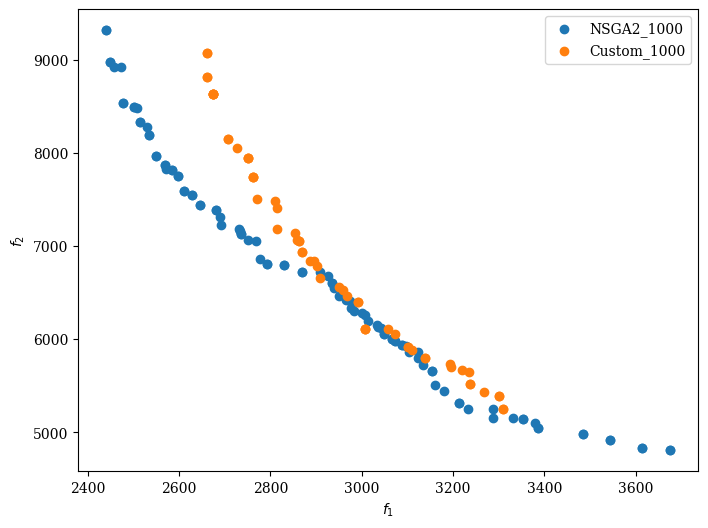

In [121]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [122]:
def mutate_hibrida(ind, pmut, gen, max_gen):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.
    Incluye mutación adaptativa y otros operadores como mutación uniforme o polinomial.
    """
    mutation_operators = [
        mutate_adaptive_gaussian,  # Mutación gaussiana adaptativa
        polynomial_mutation,       # Mutación polinomial
        mutate_uniform,            # Mutación uniforme
        mutate_gaussian            # Mutación gaussiana simple
    ]

    # Elegir aleatoriamente un operador de mutación
    mutation_operator = np.random.choice(mutation_operators)

    if mutation_operator == mutate_adaptive_gaussian:
        # Si es mutación adaptativa gaussiana, se pasan los parámetros adicionales
        return mutation_operator(ind, pmut, gen, max_gen)
    else:
        # Para los demás operadores
        return mutation_operator(ind, pmut)

In [123]:
def mantener_extremos(poblacion, valores_objetivo):
    """
    Retorna las soluciones con los mejores valores individuales en cada objetivo.
    """
    extremos_indices = np.argmin(valores_objetivo, axis=0)
    soluciones_extremas = [poblacion[extremos_indices[0]], poblacion[extremos_indices[1]]]
    return soluciones_extremas

def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2, elitism=True):
    # Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    nd_sort = NonDominatedSorting()
    prev_front_size = 0  # Variable para guardar el tamaño del frente anterior

    for gen in range(1, n_generations + 1):
        # Selección de padres (torneo multiobjetivo)
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        # **Añadir siempre los extremos**
        extremos = mantener_extremos(poblacion, valores_objetivo)
        padres.extend(extremos)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            padre1, padre2 = random.sample(padres, 2)
            # Cruce real-coded
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)
            # Mutación adaptativa
            hijo1 = mutate_hibrida(hijo1, pmut, gen, n_generations)
            hijo2 = mutate_hibrida(hijo2, pmut, gen, n_generations)
            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        valores_objetivo_nueva = evaluar_poblacion(problem, nueva_poblacion)

        # **Reinicialización parcial de la población cada 200 generaciones**
        if gen % 200 == 0:
            n_reinit = int(0.1 * n_individuals)
            nuevos_individuos = inicializar_poblacion(problem.n_var, n_reinit)
            valores_objetivo_nuevos = evaluar_poblacion(problem, nuevos_individuos)
            nueva_poblacion[:n_reinit] = nuevos_individuos
            valores_objetivo_nueva[:n_reinit] = valores_objetivo_nuevos

        # Elitismo: mantener las mejores soluciones no dominadas
        if elitism:
            no_dominadas = mantener_no_dominadas_diversas(poblacion, valores_objetivo, max_size=n_individuals // 2)
            nueva_poblacion = no_dominadas + nueva_poblacion
            nueva_poblacion = nueva_poblacion[:n_individuals]

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # **Mutación adaptativa**: aumenta si no hay mejoras en el frente
        nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front_size = len(nd_front)  # Tamaño del frente actual
        if gen > 100 and front_size == prev_front_size:
            pmut = min(pmut * 1.5, 0.5)
        else:
            pmut = max(pmut / 1.5, 1 / problem.n_var)
        prev_front_size = front_size

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            print(f"Generación {gen}: {front_size} soluciones no dominadas.")

    # Retornar la última población y los valores objetivo
    return poblacion, valores_objetivo


In [124]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.8, 
                                                                                   pmut=0.1, 
                                                                                   trace=250, 
                                                                                   T=10,
                                                                                   elitism=True, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 55 soluciones no dominadas.
Generación 500: 46 soluciones no dominadas.
Generación 750: 46 soluciones no dominadas.
Generación 1000: 47 soluciones no dominadas.
Hipervolumen: 19136201.1365, Dispersión (SPR): 3857.4787, Espaciado (SPA): 43.6045

Ejecución 2/10:
Generación 1: 7 soluciones no dominadas.
Generación 250: 48 soluciones no dominadas.
Generación 500: 55 soluciones no dominadas.
Generación 750: 55 soluciones no dominadas.
Generación 1000: 52 soluciones no dominadas.
Hipervolumen: 26644390.8553, Dispersión (SPR): 5305.8807, Espaciado (SPA): 25.3543

Ejecución 3/10:
Generación 1: 4 soluciones no dominadas.
Generación 250: 54 soluciones no dominadas.
Generación 500: 55 soluciones no dominadas.
Generación 750: 56 soluciones no dominadas.
Generación 1000: 55 soluciones no dominadas.
Hipervolumen: 23594435.3544, Dispersión (SPR): 3997.3598, Espaciado (SPA): 16.4559

Ejecución 4/10:
Generación 1: 7 soluciones no

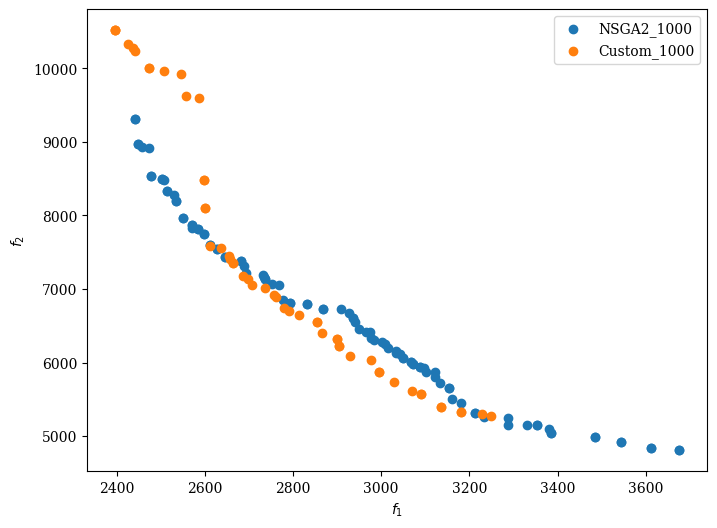

In [125]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [126]:
def tournament_by_rank_and_crowding(population, fitness, ranks, crowding_distances):
    # Randomly select two individuals for the tournament
    indices = np.random.choice(len(population), size=2, replace=False)
    i1, i2 = indices[0], indices[1]  # Separar los índices

    individual1, individual2 = population[i1], population[i2]
    fitness1, fitness2 = fitness[i1], fitness[i2]

    # Extract additional properties for comparison
    rank1, cd1 = ranks[i1], crowding_distances[i1]
    rank2, cd2 = ranks[i2], crowding_distances[i2]

    if rank1 < rank2:
        return individual1
    elif rank2 < rank1:
        return individual2

    # If rank or domination didn't make a decision, compare by crowding distance
    return (
        individual1 if cd1 > cd2 else individual2 if cd2 > cd1 else (
            individual1 if np.random.rand() < 0.5 else individual2
        )
    )

In [127]:
def calcular_crowding_distance(fitness):
    n, m = fitness.shape  # n = número de individuos, m = número de objetivos
    crowding = np.zeros(n)
    for i in range(m):
        sorted_indices = np.argsort(fitness[:, i])
        sorted_fitness = fitness[sorted_indices, i]
        crowding[sorted_indices[0]] = np.inf  # Bordes extremos
        crowding[sorted_indices[-1]] = np.inf
        for j in range(1, n - 1):
            crowding[sorted_indices[j]] += (sorted_fitness[j + 1] - sorted_fitness[j - 1]) / (
                    sorted_fitness[-1] - sorted_fitness[0] + 1e-12)
    return crowding


def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, elitism=True):
    # 1. Inicializar población con valores continuos
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    valores_objetivo = evaluar_poblacion(problem, poblacion)
    nd_sort = NonDominatedSorting()

    for gen in range(1, n_generations + 1):
        # 2. Ordenar la población por frentes no dominados
        frentes = nd_sort.do(valores_objetivo)
        ranks = np.zeros(len(valores_objetivo), dtype=int)
        for rank, frente in enumerate(frentes):
            for idx in frente:
                ranks[idx] = rank

        # 3. Calcular las distancias de crowding para cada individuo
        crowding_distances = calcular_crowding_distance(np.array(valores_objetivo))

        # 4. Selección de padres mediante torneo por rango y crowding distance
        padres = []
        while len(padres) < n_individuals:
            padre = tournament_by_rank_and_crowding(poblacion, valores_objetivo, ranks, crowding_distances)
            padres.append(padre)

        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            padre1, padre2 = random.sample(padres, 2)
            hijo1, hijo2 = sbx_crossover(padre1, padre2, pcross, 15)
            hijo1 = mutate(hijo1, pmut)
            hijo2 = mutate(hijo2, pmut)
            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        # 5. Evaluar la nueva población
        valores_objetivo_nueva = evaluar_poblacion(problem, nueva_poblacion)

        # 6. Aplicar elitismo si está activado
        if elitism:
            no_dominadas = mantener_no_dominadas_diversas(poblacion, valores_objetivo, max_size=n_individuals // 2)
            nueva_poblacion = no_dominadas + nueva_poblacion
            nueva_poblacion = nueva_poblacion[:n_individuals]

        # 7. Actualizar la población y los valores objetivo
        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Impresión de la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            print(f"Generación {gen}: {len(nd_front)} soluciones no dominadas.")

    # Retornar
    return poblacion, valores_objetivo


In [128]:
def multiple_experiments_with_metrics(problem, n_generations, n_individuals, pcross, pmut, trace=250, elitism=True, num_experiments=10):
    """
    Ejecuta el método `evolve` múltiples veces y recoge las métricas de cada ejecución.

    @param problem: Problema multiobjetivo.
    @param n_generations: Número de generaciones.
    @param n_individuals: Tamaño de la población.
    @param pcross: Probabilidad de cruce.
    @param pmut: Probabilidad de mutación.
    @param trace: Intervalo de impresión de progreso.
    @param T: Tamaño del torneo de selección.
    @param num_experiments: Número de experimentos a realizar.

    @return: Resumen de métricas y el mejor frente de Pareto encontrado.
    """
    metrics_summary = []
    best_hypervolume = -float('inf')
    pareto_nsga2 = None

    for i in range(num_experiments):
        print(f"\nEjecución {i+1}/{num_experiments}:")

        # Ejecutar `evolve`
        _, valores_objetivo = evolve(
            problem=problem,
            n_generations=n_generations,
            n_individuals=n_individuals,
            pcross=pcross,
            pmut=pmut,
            trace=trace,
            elitism=True
        )

        # Obtener el frente no dominado
        nd_sort = NonDominatedSorting()
        nd_front_indices = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front = valores_objetivo[nd_front_indices]

        # Calcular métricas
        hv, spr, spa = calculate_metrics(front)
        metrics_summary.append((hv, spr, spa))

        print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # Guardar el mejor frente según el hipervolumen
        if hv > best_hypervolume:
            best_hypervolume = hv
            pareto_nsga2 = front

    # Calcular promedios y desviaciones estándar
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return pareto_nsga2, metrics_summary

In [129]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, 
                                                                                   n_generations=1000, 
                                                                                   n_individuals=100, 
                                                                                   pcross=0.7, 
                                                                                   pmut=0.01, 
                                                                                   trace=250,
                                                                                   elitism=True, 
                                                                                   num_experiments=10)


Ejecución 1/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 52 soluciones no dominadas.
Generación 500: 50 soluciones no dominadas.
Generación 750: 52 soluciones no dominadas.
Generación 1000: 57 soluciones no dominadas.
Hipervolumen: 22522028.9629, Dispersión (SPR): 3998.7007, Espaciado (SPA): 10.7214

Ejecución 2/10:
Generación 1: 10 soluciones no dominadas.
Generación 250: 53 soluciones no dominadas.
Generación 500: 58 soluciones no dominadas.
Generación 750: 56 soluciones no dominadas.
Generación 1000: 56 soluciones no dominadas.
Hipervolumen: 23470713.8843, Dispersión (SPR): 4959.4961, Espaciado (SPA): 25.2570

Ejecución 3/10:
Generación 1: 6 soluciones no dominadas.
Generación 250: 53 soluciones no dominadas.
Generación 500: 54 soluciones no dominadas.
Generación 750: 53 soluciones no dominadas.
Generación 1000: 53 soluciones no dominadas.
Hipervolumen: 25354218.3797, Dispersión (SPR): 3634.8780, Espaciado (SPA): 13.2259

Ejecución 4/10:
Generación 1: 7 soluciones n

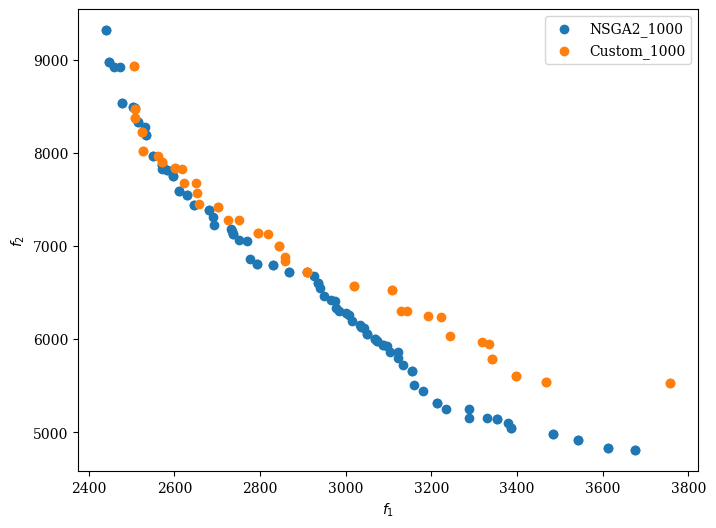

In [130]:
scatter = Scatter()
scatter.add(pareto_nsga2, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()